In [1]:
import torch
from torch import zeros, ones
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.utils import BoxUniform
from sbi.inference import prepare_for_sbi, simulate_for_sbi, SNPE, SNLE, SNRE
from sbi.analysis import pairplot
import numpy as np
from matplotlib import pyplot as plt
#import pyccl as ccl
#import pyccl.halos.profiles as prof
#import pyccl.halos.concentration as conc

In [26]:
#cosmo = ccl.core.Cosmology(Omega_c=0.27 - 0.045, Omega_b=0.045, h=0.7, n_s=0.98, 
#                     sigma8=0.8, Omega_k=0.0)

### Given the pre-made simulation data with noisy Diemer-Kravtsov, going to continue from Yuanyuan's tutorial here: https://github.com/deepskies/DeepLenSBI/blob/main/CLCosmo/sbi_test.ipynb


## Load simulation data

In [2]:
x_np = np.load('noisy_DK_NFW_profiles.npy') ##x='profiles'
np.shape(x_np)

(10000, 20)

In [3]:
logmassprior = utils.BoxUniform(low=13.7*torch.ones(1), high=14.7*torch.ones(1))
concmassprior = utils.BoxUniform(low=3*torch.ones(1), high=5*torch.ones(1))

In [4]:
prior = BoxUniform(-ones(2)*20, ones(2)*20)

In [5]:
theta_np = np.load('noisy_DK_massconc_pairs.npy')

In [6]:
np.shape(x_np)

(10000, 20)

In [7]:
np.shape(theta_np)

(2, 10000)

In [8]:
theta_np=theta_np.T

In [9]:
### for now, defining the "truth" as the first set of the simulated obs's / par's

theta_truth = theta_np[0]
x_truth = x_np[0]

In [10]:
theta = torch.as_tensor(theta_np, dtype=torch.float32)
x = torch.as_tensor(x_np, dtype=torch.float32)

In [14]:
### what is the truth here? it should just be one of the observations?
### along the line?

In [16]:
# SO the x --> PROFILES (CONVERGENCE) and then theta --> MASS+CONC
### profiles = simulateConvergenceProfile(samplemasses,noisysampleconcentrations)

## Train density estimator

In [11]:
# Create inference object: choose method and estimator
inferer = SNPE(prior, density_estimator="mdn", device="cpu")  # SNLE, SNRE

In [12]:
# Append training data
inferer = inferer.append_simulations(theta, x)

In [13]:
#Train
density_estimator = inferer.train(num_atoms=10, training_batch_size=50, 
                                  learning_rate=0.0005, 
                                  validation_fraction=0.1, 
                                  stop_after_epochs=20, max_num_epochs=1000, 
                                  clip_max_norm=5.0, calibration_kernel=None, 
                                  exclude_invalid_x=True, 
                                  resume_training=False, 
                                  discard_prior_samples=False, 
                                  use_combined_loss=False, 
                                  show_train_summary=False, 
                                  dataloader_kwargs=None)  
# Lots of training settings.


 Neural network successfully converged after 114 epochs.

## Obtain posterior

In [14]:
# Build posterior using trained density estimator
posterior = inferer.build_posterior(density_estimator)  # Posterior sampling settings.

In [15]:
# Generate samples
#theta_o = torch.as_tensor(theta_np[20], dtype=torch.float32)
#x_o = torch.as_tensor(x_np[20], dtype=torch.float32)
theta_o = torch.as_tensor(theta_truth, dtype=torch.float32) 
x_o = torch.as_tensor(x_truth, dtype=torch.float32)
samples = posterior.sample((10000,), x=x_o)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/global/homes/e/erinbari/.conda/envs/sbi_env/lib/python3.10/site-packages/pyknos/mdn/mdn.py:279: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  zero_mean_samples, _ = torch.triangular_solve(


In [22]:
pip install pygtc

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pygtc

In [19]:
#pairplot(samples[:, :5], points=theta_o, points_colors=["k"], upper="scatter", limits=[[0, 1]], figsize=(10,10));
#from matplotlib import pyplot as plt
#plt.show()



from chainconsumer import ChainConsumer
from matplotlib import pyplot as plt


np_samples=samples.numpy()
theta_truth=theta_o.numpy()
c = ChainConsumer()
#print(np.shape(np_samples))
c.add_chain(np_samples, parameters=["Mass", "Concentration"])
#fig = c.plotter.plot(figsize="column", truth=theta_truth)


In [17]:
priors2d = ((-20,20),(20,20))

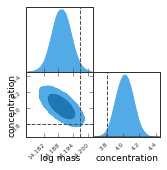

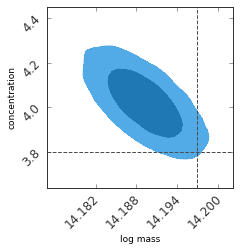

In [20]:
GTC = pygtc.plotGTC(chains=[np_samples], 
                     paramNames=['log mass','concentration'],
                     truths=theta_truth,
                     priors=priors2d,
                     figureSize='MNRAS_column')

GTC = pygtc.plotGTC(chains=[np_samples],
                    paramNames=['log mass', 'concentration'],
                    truths=theta_truth,
                    priors=priors2d,
                    figureSize='MNRAS_column',
                    do1dPlots=False, customTickFont={'family':'Arial', 'size':12})
